In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style
style.use('ggplot')
from scipy import stats
pd.options.display.max_columns=50

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

In [2]:
df_train = pd.read_csv("train.csv")

In [3]:
df_test = pd.read_csv("test.csv")

In [4]:
print(df_train.shape,df_test.shape)

(318438, 18) (137057, 17)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [6]:
df_train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [7]:
df_test.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


In [13]:
df_train.isnull().sum().sort_values(ascending= False)

City_Code_Patient                    4532
Bed Grade                             113
Stay                                    0
Ward_Type                               0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Facility_Code                      0
Admission_Deposit                       0
patientid                               0
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
case_id                                 0
dtype: int64

In [12]:
df_test.isnull().sum().sort_values(ascending= False)

City_Code_Patient                    2157
Bed Grade                              35
Admission_Deposit                       0
Department                              0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Ward_Facility_Code                      0
Ward_Type                               0
Age                                     0
patientid                               0
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
case_id                                 0
dtype: int64

In [10]:
features_with_na = [features for features in df_train.columns if df_train[features].isnull().sum()>1]
#print feature name and the percentage of missing value

for feature in features_with_na:
    print(feature, np.round(df_train[feature].isnull().mean(),4), '%missing values')

Bed Grade 0.0004 %missing values
City_Code_Patient 0.0142 %missing values


In [11]:
features_with_na = [features for features in df_test.columns if df_test[features].isnull().sum()>1]
#print feature name and the percentage of missing value

for feature in features_with_na:
    print(feature, np.round(df_test[feature].isnull().mean(),4), '%missing values')

Bed Grade 0.0003 %missing values
City_Code_Patient 0.0157 %missing values


In [16]:
for i in df_train.columns:
    print(i, ':', df_train[i].nunique())

case_id : 318438
Hospital_code : 32
Hospital_type_code : 7
City_Code_Hospital : 11
Hospital_region_code : 3
Available Extra Rooms in Hospital : 18
Department : 5
Ward_Type : 6
Ward_Facility_Code : 6
Bed Grade : 4
patientid : 92017
City_Code_Patient : 37
Type of Admission : 3
Severity of Illness : 3
Visitors with Patient : 28
Age : 10
Admission_Deposit : 7300
Stay : 11


In [17]:
for i in df_test.columns:
    print(i, ':', df_test[i].nunique())

case_id : 137057
Hospital_code : 32
Hospital_type_code : 7
City_Code_Hospital : 11
Hospital_region_code : 3
Available Extra Rooms in Hospital : 15
Department : 5
Ward_Type : 6
Ward_Facility_Code : 6
Bed Grade : 4
patientid : 39607
City_Code_Patient : 37
Type of Admission : 3
Severity of Illness : 3
Visitors with Patient : 27
Age : 10
Admission_Deposit : 6609


In [20]:
df_train['City_Code_Patient'].value_counts().sort_values(ascending=True)

38.0         6
36.0        12
35.0        16
34.0        46
32.0        52
37.0        57
31.0        59
33.0        78
29.0        98
30.0       133
24.0       360
22.0       405
28.0       521
11.0       658
27.0       771
25.0       798
26.0      1023
19.0      1028
18.0      1404
20.0      1409
21.0      1602
13.0      1625
16.0      2254
14.0      2927
23.0      3698
3.0       3772
12.0      5647
6.0       6005
10.0      8174
15.0      8950
9.0      11795
4.0      15380
5.0      20079
7.0      23807
1.0      26377
2.0      38869
8.0     124011
Name: City_Code_Patient, dtype: int64

In [22]:
df_train['City_Code_Patient'].fillna(df_train['City_Code_Patient'].mode()[0],inplace=True)
df_test['City_Code_Patient'].fillna(df_test['City_Code_Patient'].mode()[0],inplace=True)

In [21]:
df_train['Bed Grade'].fillna(df_train['Bed Grade'].mode()[0], inplace = True)
df_test['Bed Grade'].fillna(df_test['Bed Grade'].mode()[0], inplace = True)

In [23]:
df_test['Stay']=-1
df = pd.concat([df_train,df_test])

In [24]:

df.shape

(455495, 18)

In [25]:
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [26]:
df.isnull().sum()

case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

In [27]:
df['Stay'].value_counts().sort_values()

61-70                   2744
91-100                  2765
81-90                   4838
More than 100 Days      6683
71-80                  10254
41-50                  11743
0-10                   23604
51-60                  35018
31-40                  55159
11-20                  78139
21-30                  87491
-1                    137057
Name: Stay, dtype: int64

Text(0.5, 1.0, 'Count Plot of the Dependent variable')

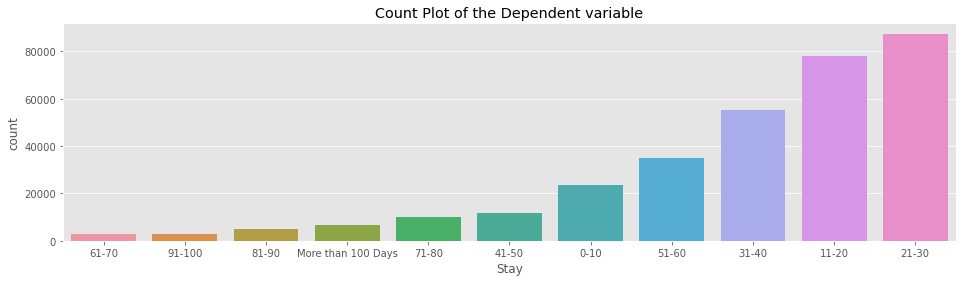

In [29]:
plt.figure(figsize=(16,4))
sns.countplot(x="Stay",data=df_train,order=df_train['Stay'].value_counts().sort_values().index)
plt.title("Count Plot of the Dependent variable")

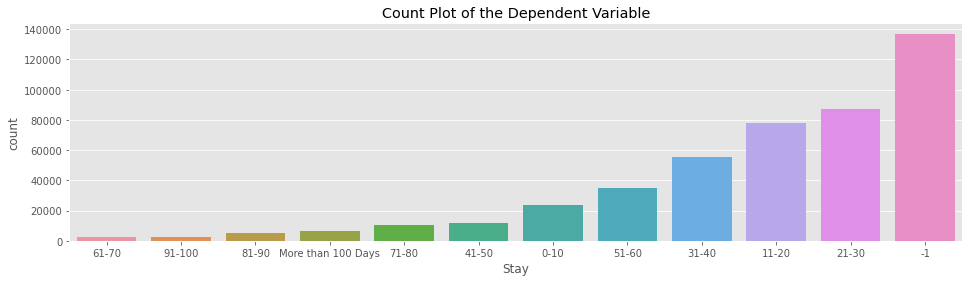

In [30]:
plt.figure(figsize=(16,4));
sns.countplot(x="Stay",data=df, order=df['Stay'].value_counts().sort_values().index);
plt.title("Count Plot of the Dependent Variable");

1)We can see that the highest number of patients are from the Age range 21-30, followed by age ranges 11-20 and 3-40.
2)We can also see that the minimum number of patients are from the Age range 61-70.
3)We can also see that there are good number of patients who stay for more than 100 days.

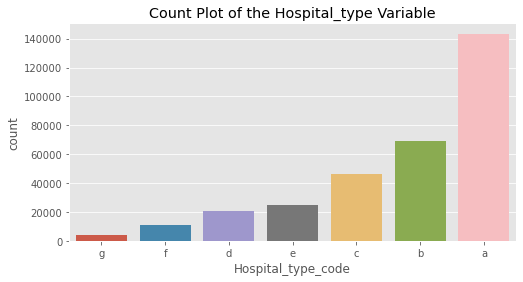

In [36]:
plt.figure(figsize=(8,4));
sns.countplot(x="Hospital_type_code",data=df_train, order=df_train['Hospital_type_code'].value_counts().sort_values().index);
plt.title("Count Plot of the Hospital_type Variable");

In [35]:
df_train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


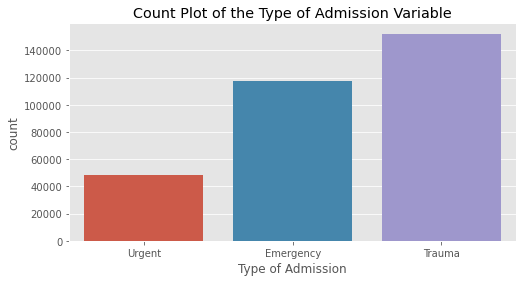

In [37]:
plt.figure(figsize=(8,4));
sns.countplot(x="Type of Admission",data=df_train, order=df_train['Type of Admission'].value_counts().sort_values().index);
plt.title("Count Plot of the Type of Admission Variable");

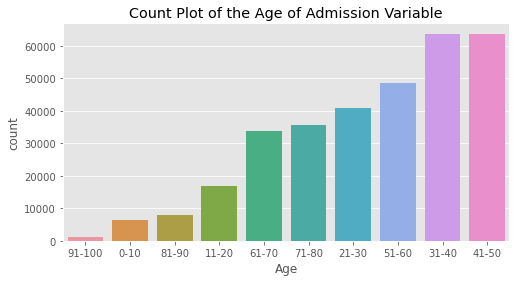

In [38]:
plt.figure(figsize=(8,4));
sns.countplot(x="Age",data=df_train, order=df_train['Age'].value_counts().sort_values().index);
plt.title("Count Plot of the Age of Admission Variable");

In [40]:
df_train['Available Extra Rooms in Hospital'].value_counts(dropna=False).sort_values()


24        1
14        1
20        2
13        2
21        3
12       13
0        15
11       17
10       67
9       218
8      1027
7      2876
1      5582
6      7786
5     19288
3     91520
4     91709
2     98311
Name: Available Extra Rooms in Hospital, dtype: int64

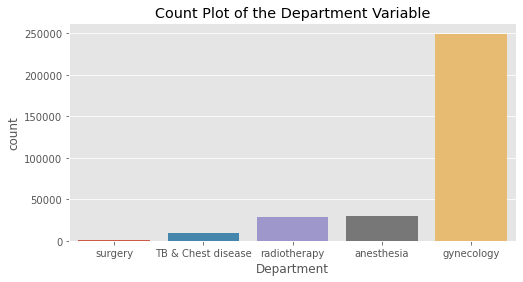

In [41]:
plt.figure(figsize=(8,4));
sns.countplot(x="Department",data=df_train, order=df_train['Department'].value_counts().sort_values().index);
plt.title("Count Plot of the Department Variable");

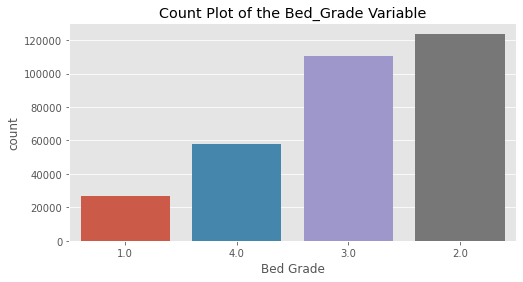

In [43]:
plt.figure(figsize=(8,4));
sns.countplot(x="Bed Grade",data=df_train, order=df_train['Bed Grade'].value_counts(dropna=False).sort_values().index);
plt.title("Count Plot of the Bed_Grade Variable");

In [44]:
df_train['Admission_Deposit'].describe()

count    318438.000000
mean       4880.749392
std        1086.776254
min        1800.000000
25%        4186.000000
50%        4741.000000
75%        5409.000000
max       11008.000000
Name: Admission_Deposit, dtype: float64

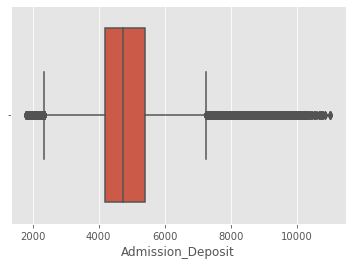

In [46]:
ax = sns.boxplot(x=df_train['Admission_Deposit'])

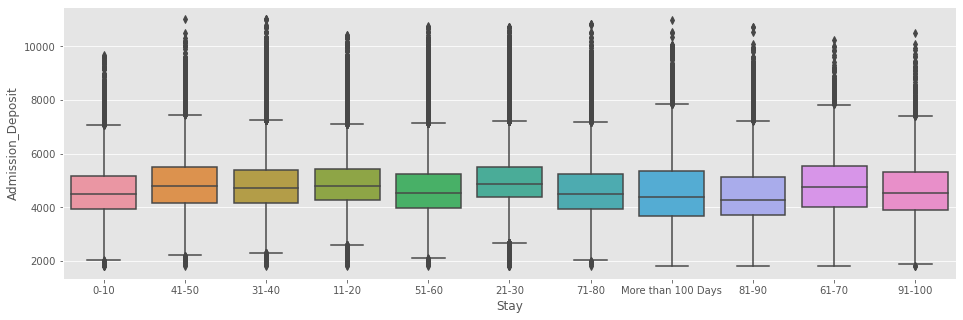

In [50]:
plt.figure(figsize=(16,5));

ax = sns.boxplot(x="Stay", y="Admission_Deposit", data=df_train)

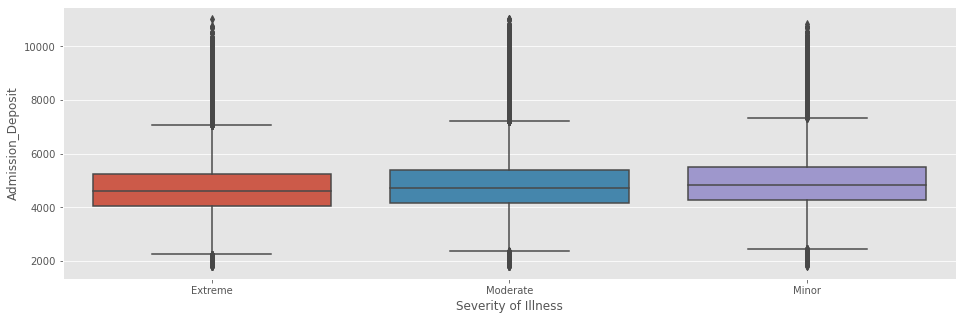

In [51]:
plt.figure(figsize=(16,5));

ax = sns.boxplot(x="Severity of Illness", y="Admission_Deposit", data=df_train)

In [53]:
IQR=df_train['Admission_Deposit'].quantile(0.75)-df_train['Admission_Deposit'].quantile(0.25)
upper_range=df_train['Admission_Deposit'].quantile(0.75)+1.5*IQR
lower_range=df_train['Admission_Deposit'].quantile(0.25)-1.5*IQR
print(upper_range,lower_range)

7243.5 2351.5


Text(0.5, 1.0, 'Distribution of the Deposit Variable')

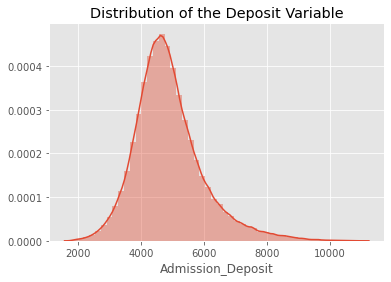

In [55]:
sns.distplot(df_train['Admission_Deposit'])
plt.title("Distribution of the Deposit Variable")

Looks like there are no outliers from the plots above.
The distribution looks almost normal.
The minimum deposit at the time of admission is 1800 and maximum is 11008 with the average amount being 4880.

# Bivariate Analysis

In [57]:
# Let's check the cross tab of the Dependent variable with the Age variable
ct = pd.crosstab(index=df_train['Age'],columns=df_train['Stay'])
ct.style.background_gradient(cmap='Blues')

Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Age,,,,,,,,,,,
0-10,615,1959,1489,1014,187,582,26,153,84,35,110
11-20,1552,5343,4312,2681,510,1429,89,350,223,71,208
21-30,3467,11272,11394,6912,1398,3793,263,1026,546,231,541
31-40,4916,15792,18550,10912,2373,6517,509,1807,801,484,978
41-50,4727,14959,17906,10983,2507,7189,562,2146,885,578,1307
51-60,3427,11346,13058,8569,1735,5739,448,1710,784,499,1199
61-70,2194,7870,9033,5930,1205,4081,325,1230,600,330,889
71-80,2201,7958,9534,6420,1383,4433,378,1367,670,386,1062
81-90,422,1392,1920,1504,379,1082,115,402,216,132,326


In [58]:
# Majority of the patients admitted for more than 100 days are from the age group 41-50 closely followed by 51-60 and 71-80.
# Age groups 31-40 and 41-50 form the majority of patients admitted for 31-40 days.
# 31-40 for the majority group in 21-30 days at the hospital.

In [59]:
# Let's check the cross tab of the Dependent variable with the Severity variable


In [62]:
ct = pd.crosstab(index=df_train['Severity of Illness'],columns=df_train['Stay'])
ct.style.background_gradient(cmap='Blues')

Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Severity of Illness,,,,,,,,,,,
Extreme,3399,10518,15502,10086,2351,7777,647,2575,1113,805,1950
Minor,7866,27081,21535,14447,3000,7128,519,1928,985,425,958
Moderate,12339,40540,50454,30626,6392,20113,1578,5751,2740,1535,3775


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

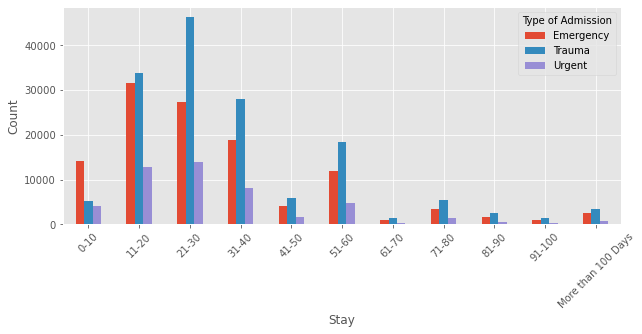

In [63]:
# Let's check the cross tab of the Dependent variable with the Admission_Type variable
df_train.groupby("Stay")['Type of Admission'].value_counts().unstack().plot.bar(figsize=(10,4))
plt.ylabel("Count")
plt.xticks(rotation=45)

In [64]:

ct = pd.crosstab(index=df_train['Age'],columns=df_train['Department'])
ct.style.background_gradient(cmap='Reds')

Department,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
Age,,,,,
0-10,387,464,4362,943,98
11-20,694,1315,13021,1694,44
21-30,1237,3320,33437,2771,78
31-40,1563,5030,53296,3626,124
41-50,1717,5608,52212,4031,181
51-60,1858,4875,37798,3779,204
61-70,1308,3860,24460,3864,195
71-80,704,4062,24925,5903,198
81-90,76,913,5236,1598,67


In [66]:
from sklearn.preprocessing import LabelEncoder
for i in ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age']:
    le=LabelEncoder()
    df[i] = le.fit_transform(df[i].astype('str'))
    

In [67]:
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,2,3,2,3,3,2,5,2.0,31397,7.0,0,0,2,5,4911.0,0-10
1,2,2,2,5,2,2,3,3,5,2.0,31397,7.0,1,0,2,5,5954.0,41-50
2,3,10,4,1,0,2,1,3,4,2.0,31397,7.0,1,0,2,5,4745.0,31-40
3,4,26,1,2,1,2,3,2,3,2.0,31397,7.0,1,0,2,5,7272.0,41-50
4,5,26,1,2,1,2,3,3,3,2.0,31397,7.0,1,0,2,5,5558.0,41-50


In [73]:
df_train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [74]:
#seggregating the df dataset
train = df[df['Stay']!=-1]
test = df[df['Stay']==-1]

In [75]:
test.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,318439,21,2,3,2,3,2,3,0,2.0,17006,2.0,0,2,2,7,3095.0,-1
1,318440,29,0,4,0,2,2,3,5,2.0,17006,2.0,1,2,4,7,4018.0,-1
2,318441,26,1,2,1,3,2,1,3,4.0,17006,2.0,0,2,3,7,4492.0,-1
3,318442,6,0,6,0,3,2,1,5,2.0,17006,2.0,1,2,3,7,4173.0,-1
4,318443,28,1,11,0,2,2,2,5,2.0,17006,2.0,1,2,4,7,4161.0,-1


In [76]:
le= LabelEncoder()
train['Stay']=le.fit_transform(train['Stay'].astype('str'))

C:\Users\haris\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
train['Stay'].sort_values(ascending=True).value_counts()

2     87491
1     78139
3     55159
5     35018
0     23604
4     11743
7     10254
10     6683
8      4838
9      2765
6      2744
Name: Stay, dtype: int64

In [81]:
print(train.shape,test.shape)

(318438, 18) (137057, 18)


In [82]:
test = test.drop(['Stay', 'patientid', 'Hospital_region_code', 'Ward_Facility_Code','case_id'], axis =1)
train = train.drop(['case_id', 'patientid', 'Hospital_region_code', 'Ward_Facility_Code'], axis =1)

In [83]:
import xgboost
classifier=xgboost.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=800, objective='multi:softmax',reg_alpha=0.5, reg_lambda=1.5,
                                 booster='gbtree', n_jobs=4, min_child_weight=2, base_score= 0.75)

In [84]:
X = train.drop('Stay', axis =1)
y = train['Stay']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state =100)

In [93]:
#converting the dataset into proper LGB format 
d_train=lgb.Dataset(X_train, label=y_train)

In [86]:
#classifier.fit(X_train, y_train)


In [87]:
train.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Available Extra Rooms in Hospital,Department,Ward_Type,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,3,3,2,2.0,7.0,0,0,2,5,4911.0,0
1,2,2,5,2,3,3,2.0,7.0,1,0,2,5,5954.0,4
2,10,4,1,2,1,3,2.0,7.0,1,0,2,5,4745.0,3
3,26,1,2,2,3,2,2.0,7.0,1,0,2,5,7272.0,4
4,26,1,2,2,3,3,2.0,7.0,1,0,2,5,5558.0,4


In [89]:
train.dtypes

Hospital_code                          int64
Hospital_type_code                     int32
City_Code_Hospital                     int64
Available Extra Rooms in Hospital      int64
Department                             int32
Ward_Type                              int32
Bed Grade                            float64
City_Code_Patient                    float64
Type of Admission                      int32
Severity of Illness                    int32
Visitors with Patient                  int64
Age                                    int32
Admission_Deposit                    float64
Stay                                   int32
dtype: object

In [90]:
params = {}
params['learning_rate'] = 0.06
params['max_depth'] = 50
params['n_estimators'] = 500
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.6
params['reg_lambda'] = 1.1

In [91]:
feature_cols = train.columns.tolist()
feature_cols.remove('Stay')
#feature_cols.remove('Admission_Deposit')
label_col = 'Stay'
print(feature_cols)

['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Available Extra Rooms in Hospital', 'Department', 'Ward_Type', 'Bed Grade', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age', 'Admission_Deposit']


In [92]:
label_col, len(feature_cols)

('Stay', 13)

In [95]:
clf = lgb.LGBMClassifier(**params)


In [96]:
df_train, df_eval = train_test_split(train, test_size=0.30, random_state=42, shuffle=True, stratify=train['Stay'])


In [97]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('Stay')
#feature_cols.remove('Admission_Deposit')
label_col = 'Stay'
print(feature_cols)

['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Available Extra Rooms in Hospital', 'Department', 'Ward_Type', 'Bed Grade', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Visitors with Patient', 'Age', 'Admission_Deposit']


In [98]:
cat_cols = feature_cols
cat_cols.remove('Admission_Deposit')
cat_cols

['Hospital_code',
 'Hospital_type_code',
 'City_Code_Hospital',
 'Available Extra Rooms in Hospital',
 'Department',
 'Ward_Type',
 'Bed Grade',
 'City_Code_Patient',
 'Type of Admission',
 'Severity of Illness',
 'Visitors with Patient',
 'Age']

In [99]:
label_col, len(feature_cols), len(cat_cols)


('Stay', 12, 12)

In [100]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

C:\Users\haris\anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Age', 'Available Extra Rooms in Hospital', 'Bed Grade', 'City_Code_Hospital', 'City_Code_Patient', 'Department', 'Hospital_code', 'Hospital_type_code', 'Severity of Illness', 'Type of Admission', 'Visitors with Patient', 'Ward_Type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_error: 0.725247	valid_0's multi_logloss: 1.87722	valid_1's multi_error: 0.725254	valid_1's multi_logloss: 1.87753
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.72492	valid_0's multi_logloss: 1.85785	valid_1's multi_error: 0.724909	valid_1's multi_logloss: 1.85859
[3]	valid_0's multi_error: 0.724844	valid_0's multi_logloss: 1.84074	valid_1's multi_error: 0.724783	valid_1's multi_logloss: 1.84211
[4]	valid_0's multi_error: 0.717374	valid_0's multi_logloss: 1.8245	valid_1's multi_error: 0.717686	valid_1's multi_logloss: 1.82629
[5]	valid_0's multi_error: 0.709025	valid_0's multi_logloss: 1.80924	valid_1's multi_error: 0.709186	valid_1's multi_logloss: 1.81145
[6]	valid_0's multi_error: 0.701699	valid_0's multi_logloss: 1.79762	valid_1's multi_error: 0.70098	valid_1's multi_logloss: 1.80005
[7]	valid_0's multi_error: 0.694629	valid_0's multi_logloss: 1.78814	valid_1's multi_error: 0.694636	valid_1's multi_logloss: 1.79085
[8]

[62]	valid_0's multi_error: 0.578037	valid_0's multi_logloss: 1.55227	valid_1's multi_error: 0.584631	valid_1's multi_logloss: 1.57002
[63]	valid_0's multi_error: 0.57784	valid_0's multi_logloss: 1.55059	valid_1's multi_error: 0.584715	valid_1's multi_logloss: 1.56858
[64]	valid_0's multi_error: 0.577871	valid_0's multi_logloss: 1.54886	valid_1's multi_error: 0.58482	valid_1's multi_logloss: 1.56707
[65]	valid_0's multi_error: 0.577746	valid_0's multi_logloss: 1.5477	valid_1's multi_error: 0.584726	valid_1's multi_logloss: 1.56619
[66]	valid_0's multi_error: 0.577593	valid_0's multi_logloss: 1.54639	valid_1's multi_error: 0.584401	valid_1's multi_logloss: 1.56512
[67]	valid_0's multi_error: 0.577468	valid_0's multi_logloss: 1.54496	valid_1's multi_error: 0.58437	valid_1's multi_logloss: 1.56395
[68]	valid_0's multi_error: 0.577212	valid_0's multi_logloss: 1.54353	valid_1's multi_error: 0.5846	valid_1's multi_logloss: 1.56275
[69]	valid_0's multi_error: 0.577046	valid_0's multi_logloss:

[123]	valid_0's multi_error: 0.569967	valid_0's multi_logloss: 1.49996	valid_1's multi_error: 0.580873	valid_1's multi_logloss: 1.53165
[124]	valid_0's multi_error: 0.56985	valid_0's multi_logloss: 1.49943	valid_1's multi_error: 0.580675	valid_1's multi_logloss: 1.53132
[125]	valid_0's multi_error: 0.569729	valid_0's multi_logloss: 1.49893	valid_1's multi_error: 0.580643	valid_1's multi_logloss: 1.53105
[126]	valid_0's multi_error: 0.569644	valid_0's multi_logloss: 1.49842	valid_1's multi_error: 0.580622	valid_1's multi_logloss: 1.53077
[127]	valid_0's multi_error: 0.569545	valid_0's multi_logloss: 1.49794	valid_1's multi_error: 0.580549	valid_1's multi_logloss: 1.53048
[128]	valid_0's multi_error: 0.569433	valid_0's multi_logloss: 1.49752	valid_1's multi_error: 0.580507	valid_1's multi_logloss: 1.53028
[129]	valid_0's multi_error: 0.56928	valid_0's multi_logloss: 1.49698	valid_1's multi_error: 0.580319	valid_1's multi_logloss: 1.52996
[130]	valid_0's multi_error: 0.569276	valid_0's mu

[184]	valid_0's multi_error: 0.564211	valid_0's multi_logloss: 1.47642	valid_1's multi_error: 0.579272	valid_1's multi_logloss: 1.52079
[185]	valid_0's multi_error: 0.564063	valid_0's multi_logloss: 1.47612	valid_1's multi_error: 0.579356	valid_1's multi_logloss: 1.52071
[186]	valid_0's multi_error: 0.564081	valid_0's multi_logloss: 1.4758	valid_1's multi_error: 0.579377	valid_1's multi_logloss: 1.5206
[187]	valid_0's multi_error: 0.564085	valid_0's multi_logloss: 1.4755	valid_1's multi_error: 0.579356	valid_1's multi_logloss: 1.52052
[188]	valid_0's multi_error: 0.56404	valid_0's multi_logloss: 1.4752	valid_1's multi_error: 0.579492	valid_1's multi_logloss: 1.52042
[189]	valid_0's multi_error: 0.563946	valid_0's multi_logloss: 1.47491	valid_1's multi_error: 0.579429	valid_1's multi_logloss: 1.5203
[190]	valid_0's multi_error: 0.563897	valid_0's multi_logloss: 1.47462	valid_1's multi_error: 0.579324	valid_1's multi_logloss: 1.5202
[191]	valid_0's multi_error: 0.563767	valid_0's multi_l

[245]	valid_0's multi_error: 0.559783	valid_0's multi_logloss: 1.46055	valid_1's multi_error: 0.578686	valid_1's multi_logloss: 1.5167
[246]	valid_0's multi_error: 0.559662	valid_0's multi_logloss: 1.46031	valid_1's multi_error: 0.578926	valid_1's multi_logloss: 1.51667
[247]	valid_0's multi_error: 0.559577	valid_0's multi_logloss: 1.46007	valid_1's multi_error: 0.578853	valid_1's multi_logloss: 1.51658
[248]	valid_0's multi_error: 0.559465	valid_0's multi_logloss: 1.45985	valid_1's multi_error: 0.57879	valid_1's multi_logloss: 1.51654
[249]	valid_0's multi_error: 0.559465	valid_0's multi_logloss: 1.4596	valid_1's multi_error: 0.578769	valid_1's multi_logloss: 1.51647
[250]	valid_0's multi_error: 0.559406	valid_0's multi_logloss: 1.45933	valid_1's multi_error: 0.578654	valid_1's multi_logloss: 1.5164
[251]	valid_0's multi_error: 0.559299	valid_0's multi_logloss: 1.45912	valid_1's multi_error: 0.578581	valid_1's multi_logloss: 1.51637
[252]	valid_0's multi_error: 0.559236	valid_0's mult

[306]	valid_0's multi_error: 0.555373	valid_0's multi_logloss: 1.44772	valid_1's multi_error: 0.578152	valid_1's multi_logloss: 1.51436
[307]	valid_0's multi_error: 0.555342	valid_0's multi_logloss: 1.44752	valid_1's multi_error: 0.578162	valid_1's multi_logloss: 1.51433
[308]	valid_0's multi_error: 0.555319	valid_0's multi_logloss: 1.44732	valid_1's multi_error: 0.578173	valid_1's multi_logloss: 1.51431
[309]	valid_0's multi_error: 0.555225	valid_0's multi_logloss: 1.44713	valid_1's multi_error: 0.578183	valid_1's multi_logloss: 1.5143
[310]	valid_0's multi_error: 0.555149	valid_0's multi_logloss: 1.44695	valid_1's multi_error: 0.578131	valid_1's multi_logloss: 1.51429
[311]	valid_0's multi_error: 0.554992	valid_0's multi_logloss: 1.44678	valid_1's multi_error: 0.578068	valid_1's multi_logloss: 1.51426
[312]	valid_0's multi_error: 0.554951	valid_0's multi_logloss: 1.44659	valid_1's multi_error: 0.578099	valid_1's multi_logloss: 1.51423
[313]	valid_0's multi_error: 0.554942	valid_0's m

[367]	valid_0's multi_error: 0.551623	valid_0's multi_logloss: 1.43672	valid_1's multi_error: 0.577775	valid_1's multi_logloss: 1.51308
[368]	valid_0's multi_error: 0.551569	valid_0's multi_logloss: 1.43656	valid_1's multi_error: 0.577827	valid_1's multi_logloss: 1.51307
[369]	valid_0's multi_error: 0.551493	valid_0's multi_logloss: 1.4364	valid_1's multi_error: 0.577775	valid_1's multi_logloss: 1.51306
[370]	valid_0's multi_error: 0.551425	valid_0's multi_logloss: 1.4362	valid_1's multi_error: 0.577974	valid_1's multi_logloss: 1.51302
[371]	valid_0's multi_error: 0.551232	valid_0's multi_logloss: 1.43601	valid_1's multi_error: 0.577901	valid_1's multi_logloss: 1.51301
[372]	valid_0's multi_error: 0.551232	valid_0's multi_logloss: 1.43584	valid_1's multi_error: 0.577922	valid_1's multi_logloss: 1.513
[373]	valid_0's multi_error: 0.551138	valid_0's multi_logloss: 1.43568	valid_1's multi_error: 0.577963	valid_1's multi_logloss: 1.51299
[374]	valid_0's multi_error: 0.551093	valid_0's mult

[428]	valid_0's multi_error: 0.547953	valid_0's multi_logloss: 1.42679	valid_1's multi_error: 0.577838	valid_1's multi_logloss: 1.51228
[429]	valid_0's multi_error: 0.547818	valid_0's multi_logloss: 1.42661	valid_1's multi_error: 0.57766	valid_1's multi_logloss: 1.51224
[430]	valid_0's multi_error: 0.547778	valid_0's multi_logloss: 1.42644	valid_1's multi_error: 0.577649	valid_1's multi_logloss: 1.51222
[431]	valid_0's multi_error: 0.547747	valid_0's multi_logloss: 1.42627	valid_1's multi_error: 0.577628	valid_1's multi_logloss: 1.51219
[432]	valid_0's multi_error: 0.547616	valid_0's multi_logloss: 1.42612	valid_1's multi_error: 0.577545	valid_1's multi_logloss: 1.5122
[433]	valid_0's multi_error: 0.547554	valid_0's multi_logloss: 1.42596	valid_1's multi_error: 0.577618	valid_1's multi_logloss: 1.5122
[434]	valid_0's multi_error: 0.547527	valid_0's multi_logloss: 1.4258	valid_1's multi_error: 0.57766	valid_1's multi_logloss: 1.5122
[435]	valid_0's multi_error: 0.547468	valid_0's multi_

[489]	valid_0's multi_error: 0.544149	valid_0's multi_logloss: 1.41749	valid_1's multi_error: 0.577838	valid_1's multi_logloss: 1.51164
[490]	valid_0's multi_error: 0.544104	valid_0's multi_logloss: 1.41735	valid_1's multi_error: 0.577817	valid_1's multi_logloss: 1.51162
[491]	valid_0's multi_error: 0.544045	valid_0's multi_logloss: 1.41721	valid_1's multi_error: 0.577859	valid_1's multi_logloss: 1.51162
[492]	valid_0's multi_error: 0.544054	valid_0's multi_logloss: 1.41706	valid_1's multi_error: 0.577827	valid_1's multi_logloss: 1.51162
[493]	valid_0's multi_error: 0.543911	valid_0's multi_logloss: 1.41689	valid_1's multi_error: 0.577765	valid_1's multi_logloss: 1.51161
[494]	valid_0's multi_error: 0.543835	valid_0's multi_logloss: 1.41674	valid_1's multi_error: 0.577901	valid_1's multi_logloss: 1.51161
[495]	valid_0's multi_error: 0.543705	valid_0's multi_logloss: 1.41658	valid_1's multi_error: 0.577733	valid_1's multi_logloss: 1.5116
[496]	valid_0's multi_error: 0.543655	valid_0's m

In [101]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.06, 'max_depth': 50, 'n_estimators': 500, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.6, 'reg_lambda': 1.1}


In [102]:
df_train = pd.concat((df_train, df_eval))


In [103]:
params

{'learning_rate': 0.06,
 'max_depth': 50,
 'n_estimators': 500,
 'objective': 'multiclass',
 'boosting_type': 'gbdt',
 'subsample': 0.7,
 'random_state': 42,
 'colsample_bytree': 0.7,
 'min_data_in_leaf': 55,
 'reg_alpha': 1.6,
 'reg_lambda': 1.1}

In [104]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.44874041414655286
